# Принятие решени в бизнесе

**Цель исследования:**
- Приоритизировать гипотезы
- Запустить A/B-тест
- Проанализировать результаты и принять решение о успешном или неуспешном проведении теста.

**Ход исследования:**
- С помощью фреймворков ICE и RICE выбрать перспективные гипотезы для проведения А/В-теста.
- Провести предобработку данных
- Проверить корректность собраной информации
- Проверить наличие аномалий в выборках
- Провести статистические тесты на проверку успешности теста
- Сделать выводы на основе полученых результатов

**Описание данных**

Файл hypothesis.csv
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл orders.csv
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл visitors.csv
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Оглавление

[Часть 1. Приоритизация гипотез](#1)

[Часть 2. Анализ A/B-теста ](#2)

[Предобработка данных](#3)

[Анализ данных](#4)

[Поиск аномалий в данных](#5)

[Статистическая значимость на "сырых" данных](#6)

["Очищенные" данные](#7)

[Общий вывод](#8)

**Импорт библиотек**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
import math as mth
import warnings

#визуализация
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

## Часть 1. Приоритизация гипотез. <a id='1'></a>

In [2]:
# импорт датасета
data = pd.read_csv('/datasets/hypothesis.csv')

In [3]:
# просмотр данных
pd.set_option('display.max_colwidth', None)
data

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


**Расшифровка параметров:**

- Reach — скольких пользователей затронет изменение, которое вы хотите внести;
- Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так;
- Efforts — сколько стоит протестировать эту гипотезу.

### Фреймоврк ICE

ICE — один из самых популярных способов приоритизации задач. Добавлю новый столбец с рейтингом ICE и, для удобства, округлю значение до 3 знаков после запятой.

 Формула расчета:

$$ICE = \frac{Impact * Confidence}{Efforts}$$

In [4]:
# добавление нового столбца
data['ICE'] =round(data['Impact']*data['Confidence']/data['Efforts'],3)

# сортировка значений по полю ICE
pd.set_option('display.max_colwidth', None)
data.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000


Наиболее перспективные гипотезы по ICE:
- Запустить акцию, дающую скидку на товар в день рождения	
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

### Фреймоврк RICE

Добавлю новый столбец с рейтингом RICE и округлю значение до 3 знаков.

Формула расчета:
$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [5]:
# добавление нового столбца
data['RICE'] = data['Reach']*data['Impact']*data['Confidence']/data['Efforts']

# сортировка по полю Rice
pd.set_option('display.max_colwidth', None)
data.sort_values(by='RICE', ascending = False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000,3.0


Наиболее перспективные гипотезы по RICE:

- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

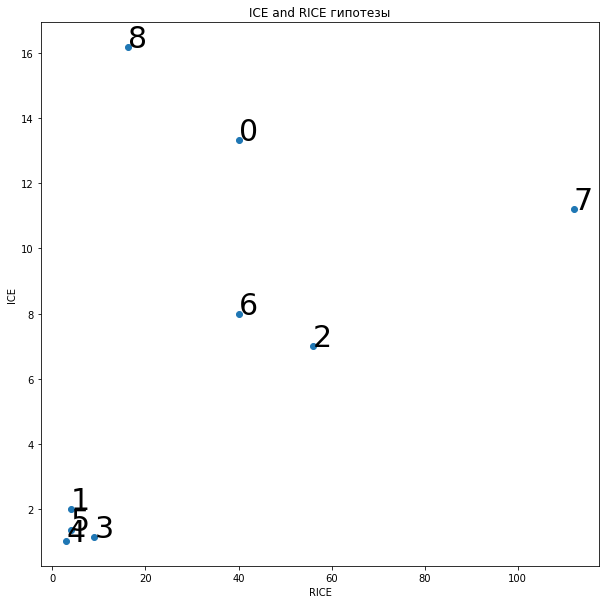

In [6]:
y = data['ICE'] 
z = data['RICE'] 
n = data.index 

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]), size=30)

plt.title("ICE and RICE гипотезы") 
plt.xlabel("RICE") 
plt.ylabel("ICE")

fig.set_figheight(10)
fig.set_figwidth(10) 
plt.show()   

### Вывод

После применения фреймворков по приоритизации гипотез, получились такие результаты:

- Наиболее перспективные гипотезы по **ICE**:
    - Запустить акцию, дающую скидку на товар в день рождения	
    - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
    - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Наиболее перспективные гипотезы по **RICE**:
    - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
    - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
    - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Разница в лидирующих гипотезах у метода Rice в том, что параметр *Reach* (скольких пользователей затронет изменение) 8-ой гипотезы равен 1, тогда как у 2-ой он равен 8.


## Часть 2. Анализ A/B-теста <a id='2'></a>

Был проведен A/B-тест и полученые результаты необходимо проанализировать.

In [7]:
#импорт датасетов
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

### Предобработка данных <a id='3'></a>

Для упрощения работы, создам функцию первичной оценки качества данных.

In [8]:
#функция для первичного просмотра данных
def check_df(data):
    head = data.head()
    info = data.info() 
    descr = data.describe()
    dupl = data.duplicated().sum() # количество дубликатов
    gaps = pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm') # количество пропусков 
    return display(head, info, descr, gaps), print('Количество дубликатов:', dupl)

**Датасет Orders**

In [9]:
#просмотр данных датасета orders
check_df(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


None

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


,0
transactionId,0.000000
visitorId,0.000000
date,0.000000
revenue,0.000000
group,0.000000


Количество дубликатов: 0


(None, None)

Кроме исправления формата в колонке дата, других проблем в датасете не обнаружено. Дополнительно приведу названия в "змеиный стиль".

In [10]:
#изменение названия
orders = orders.rename(columns = {'transactionId':'transaction_id', 'visitorId':'visitor_id'})

#изменения формата на тип даты
orders['date'] = orders['date'].astype('datetime64')

**Датасет Visitors**

In [11]:
#просмотр данных датасета visitors
check_df(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


None

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


,0
date,0.000000
group,0.000000
visitors,0.000000


Количество дубликатов: 0


(None, None)

В датасете visitors необходимо исправить тип колонки с датой.

In [12]:
#изменения формата на тип даты
visitors['date'] = visitors['date'].astype('datetime64')

Необходимо провести проверку на неявные дубликаты, а именно, убедиться, что один пользователь не попал в обе группы.

In [13]:
#делю пользователей по группам
group_a = orders[orders['group'] == 'A']['visitor_id']
group_b = orders[orders['group'] == 'B']['visitor_id']

#проверка на совпадения
match_ab = np.intersect1d(group_a,group_b)

In [14]:
match_ab

array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830])

In [15]:
print(f'Количество пересекающихся пользователей в группах: {len(match_ab)}')

Количество пересекающихся пользователей в группах: 58


Уберу данных пользователей из датасета.

In [16]:
#исключение пользователей, попавших в обе группы
orders = orders[~orders['visitor_id'].isin(match_ab)]

Проверю количество пользователей в группах.

In [17]:
print('Количество пользователей группы А:',orders[orders['group'] == 'A']['visitor_id'].nunique())
print('Количество пользователей группы В:',orders[orders['group'] == 'B']['visitor_id'].nunique())

Количество пользователей группы А: 445
Количество пользователей группы В: 528


Группы не равны, и при небольшой выборке, разница в 83 человек может значительно исказить выводы по проведенному А/Б-тесту.

In [18]:
#минимальная и максимальные даты
orders['date'].min(),orders['date'].max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2019-08-31 00:00:00'))

In [19]:
#минимальная и максимальные даты
visitors['date'].min(),visitors['date'].max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2019-08-31 00:00:00'))

Даты начала и окончания тестирования в обоих датасетах совпадают

In [20]:
# количество посещений по группам
visitors.pivot_table(index='group',values='visitors',aggfunc='sum').reset_index()

,group,visitors
0,A,18736
1,B,18916


Количетсво посещений различается незначительно, значит разница в количестве человек в группах не будет являться критичной.

### Вывод

- На предобработке данных были исправлены форматы даты и удалены пользователи, попавшие в обе группы. Явных дубликатов и пропущенных значений обнаружено не было. Название некоторых колонок были приведены к змеиному стилю.
- Была обнаружена разница в группах в размере 83 человек. Однако, количество посещений различается незначительно, поэтому разница  в группах не будет являться критичной.

### Анализ данных <a id='4'></a>

Подготовка данных для построения графиков.

In [21]:
# имассив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

In [22]:
# агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                    orders['group'] == x['group'])]\
    .agg({'date' : 'max',
          'group' : 'max',
          'transaction_id' : 'nunique',
          'visitor_id' : 'nunique',
          'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [23]:
# агрегированные кумулятивные по дням данные о посетителях 
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                      visitors['group'] == x['group'])]\
    .agg({'date' : 'max',
          'group' : 'max',
          'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [24]:
# объединение кумулятивных данных в одну таблицу
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

#первые 5 строк
cumulative_data.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [25]:
cumulative_data['date'].min(), cumulative_data['date'].max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2019-08-31 00:00:00'))

Даты совпадают с изначальным датафреймом.

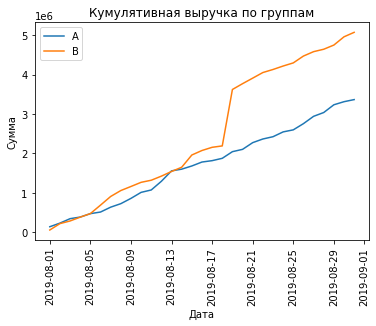

In [26]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.title('Кумулятивная выручка по группам') 
plt.xticks(rotation=90)
plt.ylabel('Сумма')
plt.xlabel('Дата')
plt.legend();

Выручка планомерно растет у обоих групп в течении всего теста. Но у группы В присутствует резкий скачок. Вероятно, это связано со всплеском числа заказов, либо с появлением очень дорогих заказов в выборке.

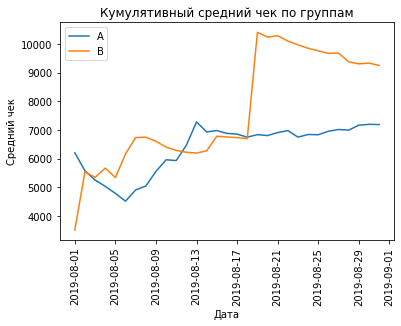

In [27]:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')

plt.title('Кумулятивный средний чек по группам')
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend();

Распределение среднего чека у группы В неравномерно, также присутствует резкий подъем. Более вероятно, что выбросы связаны с дорогими заказами. У группы А распределение нормализовалось ближе к середине теста.

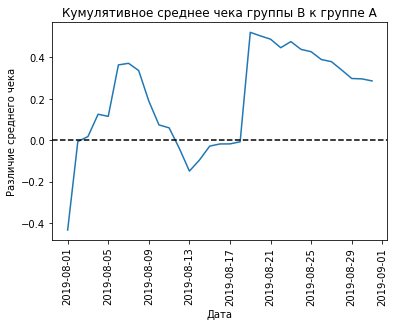

In [28]:
# данные в одном датафрейме
merged_c_revenue = cumulative_revenue_a.merge(
                                        cumulative_revenue_b,
                                        left_on='date', right_on='date',
                                        how='left', suffixes=['A', 'B'])

# график отношения средних чеков
plt.plot(merged_c_revenue['date'],
         (merged_c_revenue['revenueB']/merged_c_revenue['ordersB']
         )/(merged_c_revenue['revenueA']/merged_c_revenue['ordersA'])-1)

# ось X
plt.xticks(rotation=90)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Кумулятивное среднее чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Различие среднего чека');

В нескольких точках график различия между сегментами резко поднимается и падает. Это говорит о наличии выбросов в выборке. 

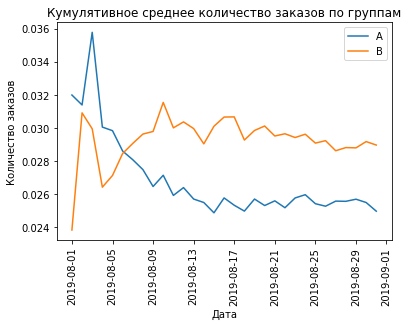

In [29]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')

plt.title('Кумулятивное среднее количество заказов по группам')
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend();

Конверсия группы А после скачка продолжает падать на протяжении всего времени тестирования. Конверсия группы В выше и постепенно нормализуется.

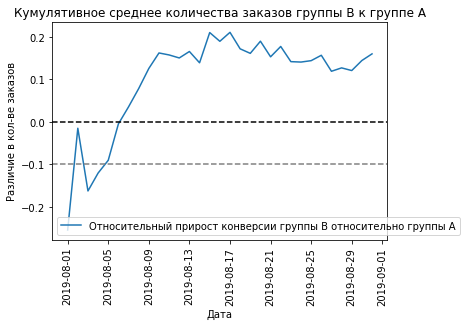

In [30]:
merged_сml_сonversions = cumulative_data_a[['date','conversion']].merge(
                                                                cumulative_data_b[['date','conversion']],
                                                                left_on='date', right_on='date',
                                                                how='left', suffixes=['A', 'B'])

plt.plot(merged_сml_сonversions['date'],
         merged_сml_сonversions['conversionB']/merged_сml_сonversions['conversionA']-1,
         label="Относительный прирост конверсии группы B относительно группы A")

plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.title('Кумулятивное среднее количества заказов группы B к группе A')
plt.xticks(rotation=90)
plt.ylabel('Различие в кол-ве заказов')
plt.xlabel('Дата');

График различий также говорит о том, что конверсия у группы В выше, чем у группы А.

### Вывод

Анализ графиков показал, что:
- Группа А: кумулятивная вырочка постепенно растет, средний чек выровнялся приблизительно к середине теста, однако конверсия падает.
- Группа В: выручка и средний чек растут,конверсия высокая. Но присутсвуют резкие скачки, говорящие о наличии либо большого числа заказов, либо о дорогих заказов.

Можно сделать вывод, что в выборке есть выбросы, а также большее количество людей в группе В влияет на общую картину. Необходимо проверить датасет и почистить данные.

### Поиск аномалий в данных <a id='5'></a>

In [31]:
# сводная таблица по количеству заказов на пользователя
by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
# переименование колонок
by_users.columns = ['user_id', 'orders']
# просмотр таблицы
by_users.sort_values(by='orders', ascending=False).head(10)

,user_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


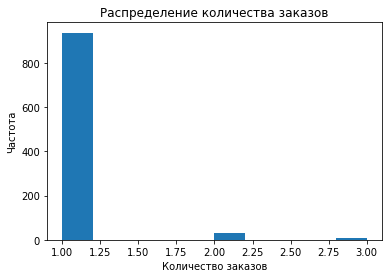

In [32]:
# график распределения количества заказов
plt.hist(by_users['orders'])
plt.title('Распределение количества заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Частота');

Основная масса покуптелей делает только один заказ. И есть доля тех, кто сделал 2-3 заказа.

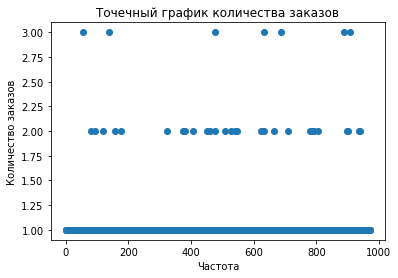

In [33]:
# точечный график количества заказов
x_values = pd.Series(range(0,len(by_users)))
plt.scatter(x_values, by_users['orders'])
plt.title('Точечный график количества заказов')    
plt.xlabel('Частота')
plt.ylabel('Количество заказов');

 Много пользователей с 2 заказами. Их точная доля не ясна — непонятно, считать ли их аномалиями. Покупателей с 3 заказами гораздо меньше.

In [34]:
# подсчет перцентилей
np.percentile(by_users['orders'], [95, 99])

array([1., 2.])

Не более 1% процента пользователей в выборке сделали больше 2 заказов. Значит верхнюю границу можно провести по 1 заказу и очистить данные от аномалий в 2-3.

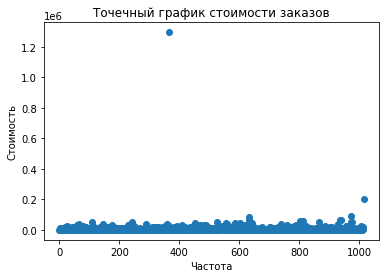

In [35]:
# точечный график стоимости заказов
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимости заказов')    
plt.xlabel('Частота')
plt.ylabel('Стоимость');

На графике присутсвуют два выброса. Один из них показывает самый дорогой заказ из свех, что присутствуют в данных.

In [36]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

В датасете не более 5% заказов дороже 26 785 рублей и не более 1% дороже 53 904 рублей. Провести верхнюю границу по стоимости заказов можно по 95 перцентилю.

### Вывод

Анализ аномалий показал:

- Не более 1% процента пользователей в выборке сделали больше 2 заказов. Верхнюю границу можно провести по 1 заказу и очистить данные от аномалий в 2-3.
- В датасете не более 5% заказов дороже 26 785 рублей и не более 1% дороже 53 904 рублей. Провести верхнюю границу по стоимости заказов можно по 95 перцентилю.

### Статистическая значимость на "сырых" данных <a id='6'></a>

Подготовлю данные для подсчета.

In [37]:
# количество пользователей в выбранную дату в группе A
visitors_ad = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_ad.columns = ['date', 'visitors_per_date_a']

# количество пользователей до выбранной даты включительно в группе A
visitors_ac = visitors_ad.apply(
    lambda x: visitors_ad[visitors_ad['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_ac.columns = ['date', 'visitors_ac']

In [38]:
# количество заказов в выбранную дату в группе A
orders_ad = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_ad.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

# суммарное число заказов до выбранной даты включительно в группе A
orders_ac = orders_ad.apply(
    lambda x: orders_ad[orders_ad['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_ac.columns = [
    'date',
    'orders_ca',
    'revenue_ca',
]

In [39]:
# количество заказов в выбранную дату в группе B
visitors_bd = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_bd.columns = ['date', 'visitors_per_date_b']

# количество пользователей до выбранной даты включительно в группе B
visitors_bc = visitors_bd.apply(
    lambda x: visitors_bd[visitors_bd['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_bc.columns = ['date', 'visitors_bc']

In [40]:
# количество заказов в выбранную дату в группе B
orders_bd = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_bd.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

# суммарное число заказов до выбранной даты включительно в группе B
orders_bc = orders_bd.apply(
    lambda x: orders_bd[orders_bd['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_bc.columns = [
    'date',
    'orders_cb',
    'revenue_cb',
]

In [41]:
# итоговый датасет
data = (
    orders_ad.merge(
        orders_bd, left_on='date', right_on='date', how='left'
    )
    .merge(orders_ac, left_on='date', right_on='date', how='left')
    .merge(orders_bc, left_on='date', right_on='date', how='left')
    .merge(visitors_ad, left_on='date', right_on='date', how='left')
    .merge(visitors_bd, left_on='date', right_on='date', how='left')
    .merge(visitors_ac, left_on='date', right_on='date', how='left')
    .merge(visitors_bc, left_on='date', right_on='date', how='left')
)

In [42]:
data.head(5)

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_ca,revenue_ca,orders_cb,revenue_cb,visitors_per_date_a,visitors_per_date_b,visitors_ac,visitors_bc
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Создам переменные orders_usA и orders_usB. В них для пользователей, которые заказывали хотя бы 1 раз, будет указано число совершённых заказов.

In [43]:
# заказы группы А
orders_usA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_usA.columns = ['user_id', 'orders']

In [44]:
# заказы группы В
orders_usB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_usB.columns = ['user_id', 'orders'] 

Создам еще две переменные, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто не совершал заказы, будут соответствовать нули. 

In [45]:
# группа А
sampleA = pd.concat(
    [orders_usA['orders'],
     pd.Series(0,
               index=np.arange(
                   data['visitors_per_date_a'].sum() - len(orders_usA['orders'])
               ),
               name='orders')],axis=0)

In [46]:
# группа В
sampleB = pd.concat(
    [orders_usB['orders'],
     pd.Series(0,
               index=np.arange(
                   data['visitors_per_date_b'].sum() - len(orders_usB['orders'])
               ),
               name='orders')],axis=0)

**Гипотезы**
- Нулевая: различий в среднем количестве заказов между группами нет.
- Альтернативная: различия в среднем между группами есть.

In [47]:
print('P-value:',"{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Различия между группами:',"{0:.5f}".format(sampleB.mean() / sampleA.mean() - 1))

P-value: 0.01102
Различия между группами: 0.15980


P-value ниже 0.05. Значит, отвергаем нулевую гипотезу. Среднее колтчество заказов группы B на 16% выше среднего группы A.

**Гипотезы**
- Нулевая: различий в среднем чеке между группами нет.
- Альтернативная: различия в среднем между группами есть.

In [48]:
print('P-value:','{0:.5f}'.format(
    stats.mannwhitneyu(
        orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

print('Различия между группами:','{0:.5f}'.format(
    orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value: 0.82949
Различия между группами: 0.28660


P-value сильно больше 0.05. Значит, причин отвергать нулевую гипотезу также нет. Но средний чек группы B выше на 28.7% среднего чека группы A.

Проверю, сколько аномальных пользователей в датасете

In [49]:
# переменная с пользователями больше 1 заказа
usersWithManyOrders = pd.concat(
    [orders_usA[orders_usA['orders'] > np.percentile(orders_usA['orders'], [95, 99])[1]]['user_id'],
     orders_usB[orders_usB['orders'] > np.percentile(orders_usB['orders'], [95, 99])[1]]['user_id'],
    ],axis=0,)

# сумма заказа больше 26 784 руб.
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], [95, 99])[0]]['visitor_id']

# объединение таблиц
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [50]:
# первые 5 строчек
print(abnormalUsers.head(5))
# количество в списке
print('Количество аномальных пользователей:',abnormalUsers.shape[0])

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64
Количество аномальных пользователей: 58


### Вывод

По различиям между **средним количеством заказов**:
- P-value ниже 0.05. Значит, отвергаем нулевую гипотезу. Среднее колтчество заказов группы B на 16% выше среднего группы A.

По различиям между **средним чеком**:
- P-value сильно больше 0.05. Значит, причин отвергать нулевую гипотезу также нет. Но средний чек группы B выше на 28.7% среднего чека группы A.

Результаты говорять о том, что при близком среднем чеке у обеих групп, среднее количество заказов у группы В выше.

При проверки выбросов было обнаружено 86 аномальных пользователей, которые будут удалены при проведении следующих тестов.

### "Очищенные" данные <a id='7'></a>

Перед проведением теста, очищу данные от аномальных пользователей.

In [51]:
# очищенные данные группы А
sampleAFiltered = pd.concat(
    [orders_usA[
        np.logical_not(
            orders_usA['user_id'].isin(abnormalUsers))]['orders'],
     pd.Series(0,index=np.arange(
         data['visitors_per_date_a'].sum() - len(orders_usA['orders'])
     ),name='orders',),],axis=0,)

In [52]:
# очищенные данные группы В
sampleBFiltered = pd.concat(
    [orders_usB[
        np.logical_not(
            orders_usB['user_id'].isin(abnormalUsers))]['orders'],
     pd.Series(0,index=np.arange(
         data['visitors_per_date_b'].sum() - len(orders_usB['orders'])),
               name='orders'),],axis=0,)

**Гипотезы**
- Нулевая: различий в среднем количестве заказов между группами нет.
- Альтернативная: различия в среднем между группами есть.

In [53]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.012
0.182


После очищения данных, P-value все еще ниже 0.05. Значит, отвергаем нулевую гипотезу. Среднее количество заказов группы B выросло на 1%, что выше среднего группы A на 17%.

**Гипотезы**
- Нулевая: различий в среднем чеке между группами нет.
- Альтернативная: различия в среднем между группами есть.

In [54]:
print('{0:.3f}'.format(stats.mannwhitneyu(
    orders[np.logical_and(orders['group'] == 'A',
                          np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                         )]['revenue'],
    orders[np.logical_and(orders['group'] == 'B',
                          np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                         )]['revenue'],)[1]))

print("{0:.3f}".format(orders[
    np.logical_and(orders['group'] == 'B',
                   np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                  )]['revenue'].mean() / orders[
    np.logical_and(orders['group'] == 'A',
                   np.logical_not(
                       orders['visitor_id'].isin(abnormalUsers)),
                  )]['revenue'].mean() - 1))

0.646
-0.048


P-value больше 0.05. Значит, причин отвергать нулевую гипотезу также нет. А средний чек группы B проигрывает среднему чеку группы A на 3%. Т.е. разница незначительна.

### Вывод

После очищения данных от анамалий, результаты тестов практически не изменились.

По различиям между **средним количеством заказов**:
- После очищения данных, P-value все еще ниже 0.05. Значит, отвергаем нулевую гипотезу. Среднее количество заказов группы B выросло на 1%, что выше среднего группы A на 17%.

По различиям между **средним чеком**:
 - P-value больше 0.05. Значит, причин отвергать нулевую гипотезу также нет. А средний чек группы B проигрывает среднему чеку группы A на 3%. Т.е. разница незначительна.

- *Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.*

По результатам проведенных тестов:    
- Есть статистически значимые различия по кол-ву заказов между группами как по "сырым", так и по "очищенным данным"
- Нет статистически значимого различия по среднему чеку между группами как по "сырым", так и по "очищенным данным"

Можно сделать вывод, что группы равны по среднему чеку, а группа B лучше группы A по конверсии. Считаю, что тест можно остановить и зафиксировать победу группы В.

## Общий вывод <a id='8'></a>

1. Приоритизация гипотез:

После применения фреймворков по приоритизации гипотез, получились такие результаты:

- Наиболее перспективные гипотезы по **ICE**:
    - Запустить акцию, дающую скидку на товар в день рождения	
    - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
    - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Наиболее перспективные гипотезы по **RICE**:
    - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
    - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
    - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Разница в лидирующих гипотезах у метода Rice в том, что параметр *Reach* (скольких пользователей затронет изменение) 8-ой гипотезы равен 1, тогда как у 2-ой он равен 8.

2. Анализ А/В теста

**Предобработка данных**

- Были исправлены форматы даты и удалены пользователи, попавшие в обе группы. Явных дубликатов и пропущенных значений обнаружено не было. Название некоторых колонок были приведены к змеиному стилю. Была обнаружена значительная разница в группах в размере 83 человек. Однако, количество посещений различается незначительно, поэтому разница  в группах не будет являться критичной.

**Анализ данных** показал, что:
- Группа А: кумулятивная вырочка постепенно растет, средний чек выровнялся приблизительно к середине теста, однако конверсия падает.
- Группа В: выручка и средний чек растут,конверсия высокая. Но присутсвуют резкие скачки, говорящие о наличии либо большого числа заказов, либо о дорогих заказов.

**Анализ аномалий** показал:

- Не более 1% процента пользователей в выборке сделали больше 2 заказов. Верхнюю границу можно провести по 1 заказу и очистить данные от аномалий в 2-3.
- В датасете не более 5% заказов дороже 26 785 рублей и не более 1% дороже 53 904 рублей. Провести верхнюю границу по стоимости заказов можно по 95 перцентилю.

**Статистическая значимость на сырых данных**

По различиям между средним количеством заказов:
- P-value ниже 0.05. Значит, отвергаем нулевую гипотезу. Среднее колтчество заказов группы B на 16% выше среднего группы A.

По различиям между средним чеком:
- P-value сильно больше 0.05. Значит, причин отвергать нулевую гипотезу также нет. Но средний чек группы B выше на 28.7% среднего чека группы A.

Результаты говорять о том, что при близком среднем чеке у обеих групп, среднее количество заказов у группы В выше.
При проверки выбросов было обнаружено 86 аномальных пользователей, которые были удалены при проведении следующих тестов.

**Статистическая значимость на очищеных данных**

После очищения данных от анамалий, результаты тестов практически не изменились.

По различиям между средним количеством заказов:
- После очищения данных, P-value все еще ниже 0.05. Значит, отвергаем нулевую гипотезу. Среднее количество заказов группы B выросло на 1%, что выше среднего группы A на 17%.

По различиям между средним чеком:
 - P-value больше 0.05. Значит, причин отвергать нулевую гипотезу также нет. А средний чек группы B проигрывает среднему чеку группы A на 3%. Т.е. разница незначительна.
 
**Итог**

По результатам проведенных тестов:    
- Есть статистически значимые различия по кол-ву заказов между группами как по "сырым", так и по "очищенным данным"
- Нет статистически значимого различия по среднему чеку между группами как по "сырым", так и по "очищенным данным"

Можно сделать вывод, что группы равны по среднему чеку, а группа B лучше группы A по конверсии. Считаю, что тест можно остановить и зафиксировать победу группы В.